## **Environment Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/neural_networks_notebooks

/content/drive/MyDrive/neural_networks_notebooks


In [ ]:
pwd

'/content/drive/MyDrive/neural_networks_notebooks'

## Lab 2 – Sequence Classification with LSTMClassifier and Comparison to RNN

This lab builds on Lab 1 and uses **LSTMs** for the same dataset.



### 1. Learning objectives

By the end of this lab, you should be able to:

1. Use PyTorch’s `nn.LSTM` for sequence classification.
2. Understand and implement the forward pass that uses only the final time step for classification.
3. Compare performance and training behavior of an LSTM vs. the simple RNN from Lab 1.
4. Interpret results in the context of vanishing and exploding gradients.

---



### 2. Dataset

Use the **same dataset and preprocessing pipeline** as in Lab 1, so you can compare results directly:

* Same train/test split
* Same normalization
* Same shapes: `(B, T, 1)`

---


### 3. Provided LSTM architecture

You are given:

```python
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (B, T, D)
        out, (h_n, c_n) = self.lstm(x)
        # out: (B, T, hidden_size)
        # h_n: (num_layers, B, hidden_size)
        # c_n: (num_layers, B, hidden_size)
        last_hidden = out[:, -1, :]   # (B, hidden_size)
        logits = self.fc(last_hidden)
        return logits
```

You must use this as the base and configure its hyperparameters.

---



### 4. Task A – Instantiate and inspect the LSTM classifier

1. Use:

   * `input_size = 1` (same as before)
   * `hidden_size` = 32 or 64
   * `num_layers` = 1 initially
   * `num_classes` as before
2. Print:

   * Model architecture
   * Number of trainable parameters
3. Ensure that a single forward pass works:

   * Create a dummy batch `x_dummy` of shape `(B=4, T=seq_len, D=1)`, and verify:

     ```python
     logits = model(x_dummy)
     print(logits.shape)   # should be (4, num_classes)
     ```



Deliverables:

* Code and output that confirm the model compiles and runs.

---



### 5. Task B – Train the LSTM classifier

Follow the same training procedure as in Lab 1:

1. Use the same loss (`CrossEntropyLoss`) and optimizer (e.g., `Adam`).
2. Train for 20–30 epochs.
3. Track:

   * Training loss vs. epoch
   * Training accuracy vs. epoch
   * Test accuracy after training

Try to use the **same batch size** and, as far as possible, similar learning rate as in Lab 1.

Deliverables:

* Training loop code (very similar structure to Lab 1).
* Plots and printed logs of loss and accuracy.
* Final train and test accuracy.

---



### 6. Task C – Hyperparameter experiments

Run at least two more configurations:

1. `hidden_size = 16`, `num_layers = 1`
2. `hidden_size = 64`, `num_layers = 2`

For each configuration, record:

* Training accuracy
* Test accuracy
* Observations: does deeper (more layers) always help on this dataset?

Deliverables:

* A small results table, for example:

  | Model      | hidden_size | num_layers | Train Acc | Test Acc |
  | ---------- | ----------- | ---------- | --------- | -------- |
  | Simple RNN | 32          | 1          |           |          |
  | LSTM       | 32          | 1          |           |          |
  | LSTM       | 64          | 2          |           |          |

---



### 7. Task D – Comparative analysis (written)

Write a answers addressing the following questions.

1. Which model performed better: simple RNN from Lab 1 or LSTM from Lab 2?
2. Did the LSTM converge faster, more stably, or to a better final accuracy?
3. Relate the behavior to theory:

   * How does the LSTM’s cell state and gating mechanism help with vanishing gradients compared to the plain tanh RNN?
   * Based on your results, do you see evidence that the LSTM is better at capturing longer-range structure in the time series?
4. Mention at least one limitation or drawback of the LSTM:

   * More parameters
   * Slower per-epoch training
   * Harder to tune?

Deliverables:

* Answers appended to the notebook below the task description.

---


In [1]:
import torch, torch.nn as nn, numpy as np, pandas as pd, os, urllib.request, zipfile
from torch.utils.data import Dataset, DataLoader
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_xh = nn.Linear(input_size, hidden_size, bias=True)
        self.W_hh = nn.Linear(hidden_size, hidden_size, bias=False)

    def forward(self, x_t, h_prev):
        # x_t: (B, input_size)
        # h_prev: (B, hidden_size)
        h_t = torch.tanh(self.W_xh(x_t) + self.W_hh(h_prev))
        return h_t

def run_simple_rnn(cell, x):
    # x: (B, T, input_size)
    B, T, _ = x.shape
    h = torch.zeros(B, cell.hidden_size, device=x.device)
    outputs = []

    for t in range(T):
        x_t = x[:, t, :]      # (B, input_size)
        h = cell(x_t, h)      # (B, hidden_size)
        outputs.append(h.unsqueeze(1))

    # outputs: (B, T, hidden_size)
    return torch.cat(outputs, dim=1), h


In [54]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.rnn_cell = SimpleRNNCell(input_size, hidden_size)
        self.hidden_size = hidden_size
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (B, T, D)
        out_seq, h_last = run_simple_rnn(self.rnn_cell, x)
        # Use final hidden state h_last: (B, hidden_size)
        logits = self.fc(h_last)  # (B, num_classes)
        return logits

In [2]:
#@title Load train/test into PyTorch Dataset
def load_ucr(fp):
    arr = np.loadtxt(fp)
    y = arr[:,0].astype(int) - 1  # labels 0..4
    X = arr[:,1:].astype(np.float32)
    return X, y

try:
    Xtr, ytr = load_ucr("./ECG5000/ECG5000_TRAIN.txt")
    Xte, yte = load_ucr("./ECG5000/ECG5000_TEST.txt")
except:
    Xtr, ytr = load_ucr("ECG5000_TRAIN.txt")
    Xte, yte = load_ucr("ECG5000_TEST.txt")





In [3]:
# min max normalization
def normalize_per_series(X):
    min_ = X.min(axis=1, keepdims=True)
    max_ = X.max(axis=1, keepdims=True)
    return (X - min_) / (max_-min_) 


Xtr = normalize_per_series(Xtr)
Xte = normalize_per_series(Xte)


In [4]:
Xtr = Xtr.reshape([*Xtr.shape[:2], 1])
Xte = Xte.reshape([*Xte.shape[:2], 1])


In [5]:
class ECG(Dataset):
    def __init__(self, X, y): self.X=torch.from_numpy(X); self.y=torch.from_numpy(y).long()
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]
train_dl = DataLoader(ECG(Xtr,ytr), batch_size=64, shuffle=True)
test_dl  = DataLoader(ECG(Xte,yte), batch_size=64, shuffle=False)
print("Shapes:", next(iter(train_dl))[0].shape)

Shapes: torch.Size([64, 140, 1])


# TASK A

In [6]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (B, T, D)
        out, (h_n, c_n) = self.lstm(x)
        # out: (B, T, hidden_size)
        # h_n: (num_layers, B, hidden_size)
        # c_n: (num_layers, B, hidden_size)
        last_hidden = out[:, -1, :]   # (B, hidden_size)
        logits = self.fc(last_hidden)
        return logits

In [13]:
x_dummy = torch.tensor(np.random.random([4,140,1]),dtype=torch.float32)
print(x_dummy.shape)

torch.Size([4, 140, 1])


In [14]:
lstm_model = LSTMClassifier(1, 32, 1, 5)
logits = lstm_model(x_dummy)
print(logits.shape)

torch.Size([4, 5])


# Task B

In [45]:
def train(model, epochs, loss_function, optimizer, train_data, log=1):
    train_losses = []
    train_accuracies = []

    for epoch in range(1, epochs + 1):
        # --- Training ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for xb, yb in train_data:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_function(preds, yb)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * xb.size(0)
            train_correct += (preds.argmax(dim=1) == yb).sum().item()
            train_total += xb.size(0)

        train_loss /= train_total
        train_acc = 100 * train_correct / train_total

        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        if log>0:
            print(
                f"Epoch {epoch:02d} | "
                f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
            )

    
    return train_accuracies, train_losses
# --- Evaluation ---
def test_model(model, test_dl, loss_fn):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = loss_fn(preds, yb)

            test_loss += loss.item() * xb.size(0)
            test_correct += (preds.argmax(dim=1) == yb).sum().item()
            test_total += xb.size(0)

        test_loss /= test_total
        test_acc = 100 * test_correct / test_total
    return test_loss, test_acc


In [40]:
lstm_model = LSTMClassifier(1, 32, 1, 5).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_accuracies, train_losses = train(lstm_model, 30, loss_fn, optimizer, train_dl)


Epoch 01 | Train Loss: 1.6177 | Train Acc: 2.00% | 
Epoch 02 | Train Loss: 1.5610 | Train Acc: 21.60% | 
Epoch 03 | Train Loss: 1.4843 | Train Acc: 58.60% | 
Epoch 04 | Train Loss: 1.3314 | Train Acc: 58.40% | 
Epoch 05 | Train Loss: 1.0690 | Train Acc: 58.40% | 
Epoch 06 | Train Loss: 0.9756 | Train Acc: 58.40% | 
Epoch 07 | Train Loss: 0.9224 | Train Acc: 58.40% | 
Epoch 08 | Train Loss: 0.9011 | Train Acc: 58.40% | 
Epoch 09 | Train Loss: 0.8899 | Train Acc: 58.40% | 
Epoch 10 | Train Loss: 0.8771 | Train Acc: 58.40% | 
Epoch 11 | Train Loss: 0.8611 | Train Acc: 58.40% | 
Epoch 12 | Train Loss: 0.8319 | Train Acc: 58.40% | 
Epoch 13 | Train Loss: 0.7877 | Train Acc: 63.00% | 
Epoch 14 | Train Loss: 0.6949 | Train Acc: 90.60% | 
Epoch 15 | Train Loss: 0.5686 | Train Acc: 91.40% | 
Epoch 16 | Train Loss: 0.5325 | Train Acc: 91.20% | 
Epoch 17 | Train Loss: 0.4891 | Train Acc: 91.60% | 
Epoch 18 | Train Loss: 0.4519 | Train Acc: 92.20% | 
Epoch 19 | Train Loss: 0.4265 | Train Acc: 91.6

In [41]:
test_loss, test_acc = test_model(lstm_model, test_dl, loss_fn)
print(f"final Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

final Test Loss: 0.3874 | Test Acc: 90.84%


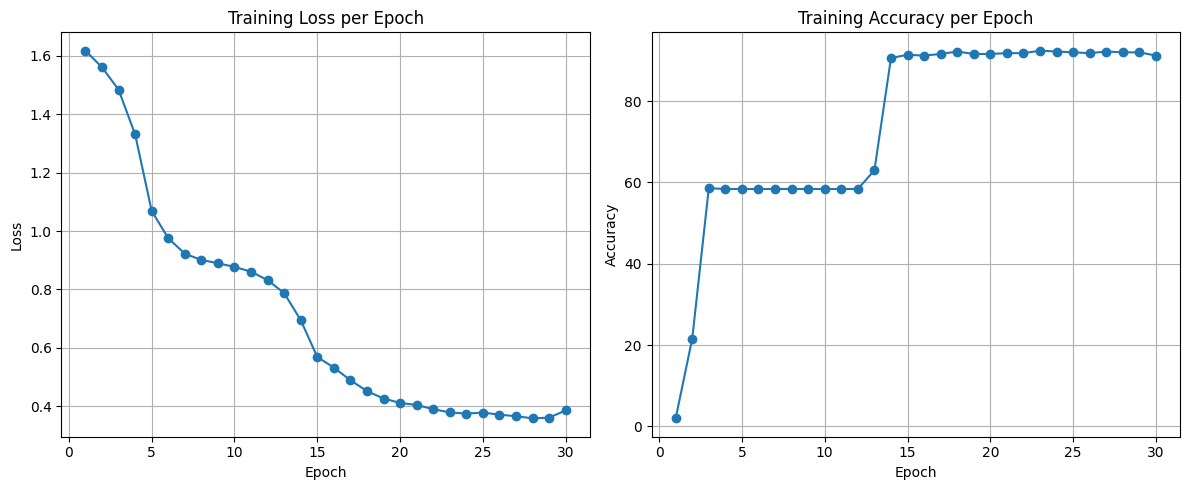

In [42]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_accuracies)+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


# Task C

In [63]:
num_layers = [1,2,3]
num_hidden_sizes = [16,32,64,128]
lstm_model_acc = {}
for num_hidden_size in num_hidden_sizes:
    print(f'training hidden size {num_hidden_size}:- ',end='')
    for num_layer in num_layers:
        print(f'layers({num_layer}),',end='')
        model = LSTMClassifier(1, num_hidden_size, num_layer, 5).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss()
        train_accuracies, train_losses = train(model, 30, loss_fn, optimizer, train_dl,log=0)
        test_loss, test_acc = test_model(model, test_dl, loss_fn)
        lstm_model_acc[num_hidden_size,num_layer] = train_accuracies[-1], test_acc
    print()

training hidden size 16:- layers(1),layers(2),layers(3),
training hidden size 32:- layers(1),layers(2),layers(3),
training hidden size 64:- layers(1),layers(2),layers(3),
training hidden size 128:- layers(1),layers(2),layers(3),


In [61]:
num_layers = [1,2,3]
num_hidden_sizes = [16,32,64,128]
RNN_model_acc = {}
for num_hidden_size in num_hidden_sizes:
    print(f'training hidden size {num_hidden_size}')
    model = SimpleRNNClassifier(1, num_hidden_size, 5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    train_accuracies, train_losses = train(model, 30, loss_fn, optimizer, train_dl,log=0)
    test_loss, test_acc = test_model(model, test_dl, loss_fn)
    RNN_model_acc[num_hidden_size,1] = train_accuracies[-1], test_acc


training hidden size 16
training hidden size 32
training hidden size 64
training hidden size 128


In [65]:
print("| Model | hidden_size | num_layers | Train Acc | Test Acc |")
print("|-------|-------------|------------|-----------|----------|")

for (h, l), (train_acc, test_acc) in lstm_model_acc.items():
    print(f"| LSTM | {h:12} | {l:10} | {train_acc:9.4f} | {test_acc:8.4f} |")
for (h, l), (train_acc, test_acc) in RNN_model_acc.items():
    print(f"|  RNN | {h:12} | {l:10} | {train_acc:9.4f} | {test_acc:8.4f} |")

| Model | hidden_size | num_layers | Train Acc | Test Acc |
|-------|-------------|------------|-----------|----------|
| LSTM |           16 |          1 |   92.2000 |  91.3778 |
| LSTM |           16 |          2 |   93.0000 |  91.5778 |
| LSTM |           16 |          3 |   92.8000 |  92.0667 |
| LSTM |           32 |          1 |   92.2000 |  91.6889 |
| LSTM |           32 |          2 |   93.2000 |  92.2444 |
| LSTM |           32 |          3 |   93.0000 |  91.9333 |
| LSTM |           64 |          1 |   92.6000 |  91.4444 |
| LSTM |           64 |          2 |   93.2000 |  92.0667 |
| LSTM |           64 |          3 |   94.2000 |  93.2889 |
| LSTM |          128 |          1 |   65.8000 |  71.3111 |
| LSTM |          128 |          2 |   93.0000 |  92.0222 |
| LSTM |          128 |          3 |   94.2000 |  93.4222 |
|  RNN |           16 |          1 |   90.2000 |  89.8000 |
|  RNN |           32 |          1 |   92.0000 |  90.0222 |
|  RNN |           64 |          1 |   9